In [49]:
!pip install keyboard


Defaulting to user installation because normal site-packages is not writeable


In [50]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import Qt
import keyboard

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
from commpy.filters import rcosfilter
from ipywidgets import interact, widgets

In [52]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [53]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)
    plt.figure(figure_counter)
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    return yf

In [54]:
def gen_rcfilter_impulse_response(n, fs):
    s_psf = rcosfilter(n * fs, alpha=0.24, Ts=1, Fs=fs)[1][1:]
    plt.figure()
    plt.plot(s_psf, '*-')
    plt.grid()
    plt.title('RC filter impulse response')
    return s_psf

In [55]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    data = np.random.randint(0, 4, n_symb)
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(N * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

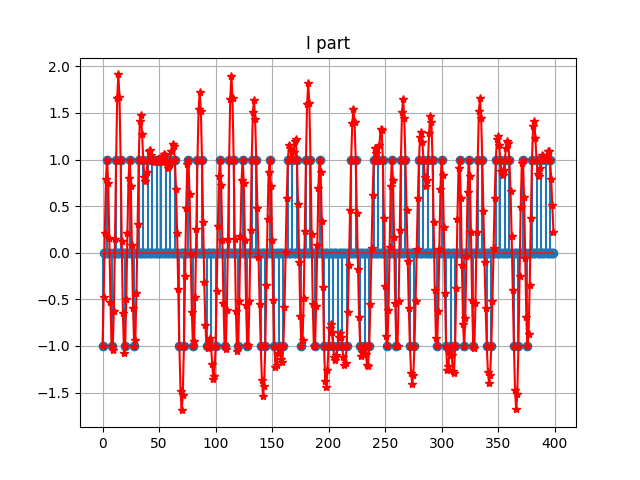

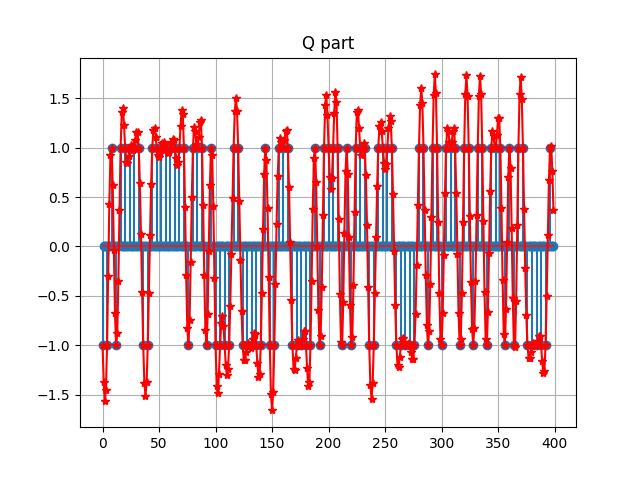

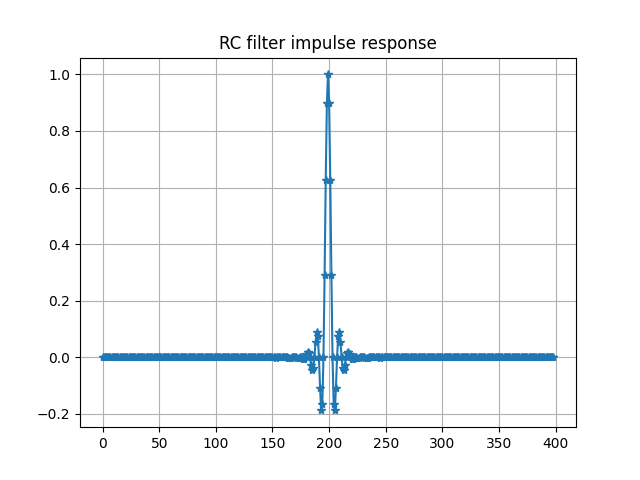

In [56]:
N = 100
Fs = 4
s_rc = gen_rcfilter_impulse_response(N, Fs)
s_qpsk = gen_qpsk_symbols(N, Fs)
qpsk_filtered = np.convolve(s_qpsk, s_rc, 'same')

plt.figure()
plt.stem(s_qpsk.real)
plt.plot(qpsk_filtered.real, 'r*-')
plt.grid()
plt.title('I part')
plt.show()

plt.figure()
plt.stem(s_qpsk.imag)
plt.plot(qpsk_filtered.imag, 'r*-')
plt.grid()
plt.title('Q part')
plt.show()

s_rc_conv = np.convolve(s_qpsk, s_rc, 'same')


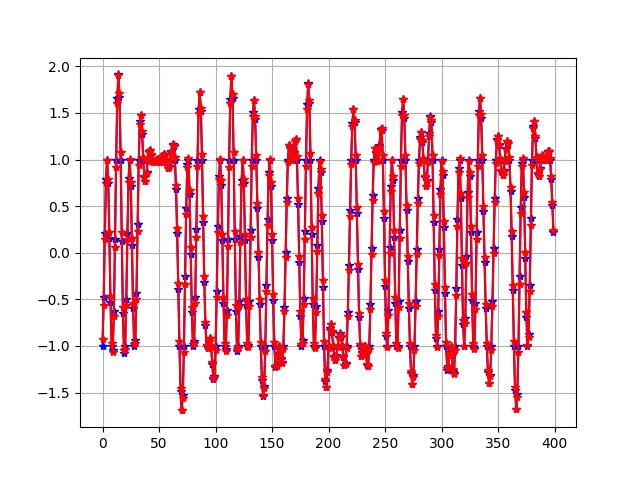

In [57]:
p = 1
q = 1
x0 = 0.1 # it is negative delay
global s_rc_re_delay 
qpsk_filt_del = resampling_lagrange(qpsk_filtered, p, q, x0)
%matplotlib widget

plt.figure()
plt.plot(qpsk_filtered,'b*-')
plt.plot(qpsk_filt_del, 'r*-')
plt.grid()
plt.show()

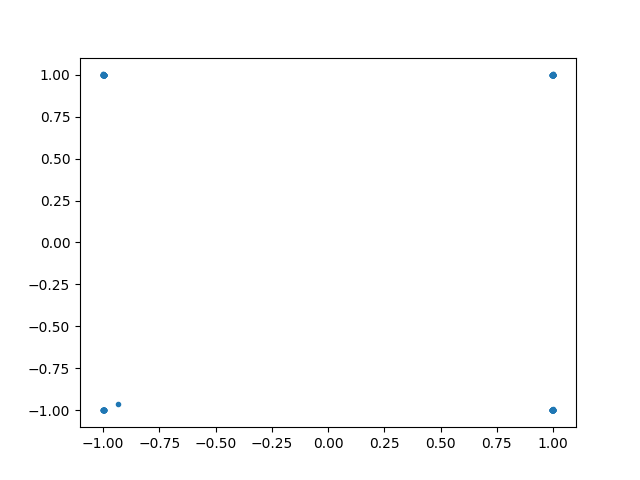

In [58]:
p = 1
q = 1
x0 = -0.1 # it is negative delay
qpsk_rec = resampling_lagrange(qpsk_filt_del, p, q, x0)
#s_rc_im_down = resampling_lagrange(s_rc_im_delay, p, q, x0)

p = 1
q = 4
x0 = 0
qpsk_rec_down = resampling_lagrange(qpsk_rec, p, q, x0)
#s_rc_im_down = resampling_lagrange(s_rc_im_down, p, q, x0)

plt.figure()
plt.plot(qpsk_rec_down.real, qpsk_rec_down.imag, '.')

In [59]:
# Initial linewidth value
linewidth = 1

# Function to handle parameter change
def change_linewidth(up=True):
    global linewidth
    if up:
        linewidth += 1
    else:
        linewidth -= 1
    plot_iq()

In [60]:
def plot_iq(delay: float, fsymb_to_fsampl: float):
    fract_omega = fsymb_to_fsampl - round(fsymb_to_fsampl)
    fsymb_to_fsampl = round(fsymb_to_fsampl)
    fract_delay = delay - round(delay)
    delay = round(delay)
    print(f"fract omega = {fract_omega}, fsymb_to_fsampl = {fsymb_to_fsampl}")
    
    qpsk_del_comp = qpsk_filt_del[delay::]
    p = 1
    q = fsymb_to_fsampl
    x0 = fract_delay # it is negative delay
    s_without_delay = resampling_lagrange(qpsk_del_comp, p, q, x0)
    
    sig_with_orig_fs = s_without_delay
    n = np.arange(0, len(sig_with_orig_fs), 1)
    mixer = np.exp(1j * np.pi * fract_omega * n)
    res_sig = sig_with_orig_fs * mixer
    
    plt.figure()
    plt.plot(res_sig.real, res_sig.imag, '.')
    plt.show()

In [61]:
delay_slider = widgets.FloatSlider(value=1.0, min=-1, max=len(qpsk_filt_del), step=0.001, description='Delay before first symbol, samples')
omega_slider = widgets.FloatSlider(value=1.0, min=1, max=100, step=0.1, description='Fsamples / Fsymbol')


# Use the interact function to connect the slider to the plot function
interact(plot_iq, delay=delay_slider, fsymb_to_fsampl=omega_slider, fract_delay=fract_delay_slider, fract_omega=fract_omega_slider)

interactive(children=(FloatSlider(value=1.0, description='Delay before first symbol, samples', max=400.0, min=…

<function __main__.plot_iq(delay: float, fsymb_to_fsampl: float)>